In [11]:
import os
print(os.getcwd())
print(os.listdir())

/home/terp/repos/customer-personality
['.git', 'venv', 'requirements.txt', 'main.py', 'data', 'data_exploration.ipynb', 'README.md', 'src', '.gitignore']


## Import Necessary Libraries

In [12]:
# Importing libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from src.data_cleaning import load_and_clean_data
from src.feature_engineering import *
from src.data_visualization import *

## Load and Clean Data

In [6]:
import pandas as pd

# Function to load and clean data in main file
def load_and_clean_data(filepath):
    data = pd.read_csv(filepath, sep="\t")
    data = data.dropna()
    data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
    data = data.rename(columns={
        "MntWines": "Wines",
        "MntFruits":"Fruits",
        "MntMeatProducts":"Meat",
        "MntFishProducts":"Fish",
        "MntSweetProducts":"Sweets",
        "MntGoldProds":"Gold"})
    return data

## Feature Engineering

#### Add Shopper Length

In [8]:
# Create list of total days each shopper has been with us
def add_shopper_length(data):
    # Ensure Dt_Customer is in datetime format
    data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)

    # Calculate the maximum date
    max_date = data["Dt_Customer"].max().date()
    
    # Calculate the difference in days for each customer
    data["Shopper_Length"] = data["Dt_Customer"].apply(lambda x: (max_date - x.date()).days)
    
    return data

#### Create Feature for Age

In [9]:
# Create list of Age from Year_Birth
def add_age(data):
    data["Age"] = 2025-data["Year_Birth"]
    return data

#### Create Feature for amount spent per Customer 

In [10]:
# Total Spending for each Customer
def calculate_spent(data):
    data["Spent"] = data["Wines"] + data["Fruits"]+ data["Meat"] + data["Fish"] + data["Sweets"] + data["Gold"]
    return data

#### Create Feature to see Living Situation

In [11]:
# To determine if individual is providing for more than themselves
def alone_or_partnered(data):
    data["Living_With"] = data["Marital_Status"].replace({
        "Married":"Partner",
        "Together":"Partner",
        "Single":"Alone",
        "Divorced":"Alone",
        "Widow":"Alone",
        "Alone":"Alone",
        "Absurd":"Alone",
        "YOLO":"Alone"
        })
    return data

#### Create Features for amount of children, family size, and if person is a parent

In [12]:
# Children Count to make Family size feature
def children_count(data):
    data["Children_Count"] = data["Kidhome"] + data["Teenhome"]
    return data

def family_size(data):
    data["Family_Size"] = data["Living_With"].replace({"Partner": 2, "Alone": 1}) + data["Children_Count"]
    return data

# Boolean 1 or 0 for if parent or not
def add_is_parent(data):
    data["Is_Parent"] = np.where(data["Children_Count"] > 0, 1, 0)
    return data

#### Group Education into three categories

In [13]:
# Group Education into three categories
def add_education(data):
    data["Education"] = data["Education"].replace({
        "Graduation": "Graduate",
        "PhD": "Higher_Education",
        "Master": "Higher_Education",
        "2n Cycle": "Undergraduate",
        "Basic": "Undergraduate"
    })
    return data

### Description of the data

###### This data includes all engineered features and cleaning up to this point.

In [4]:
import pandas as pd

# Load the pre-processed data from the main script
data = pd.read_csv('data/processed_data.csv')

### Visualization of Current Data

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

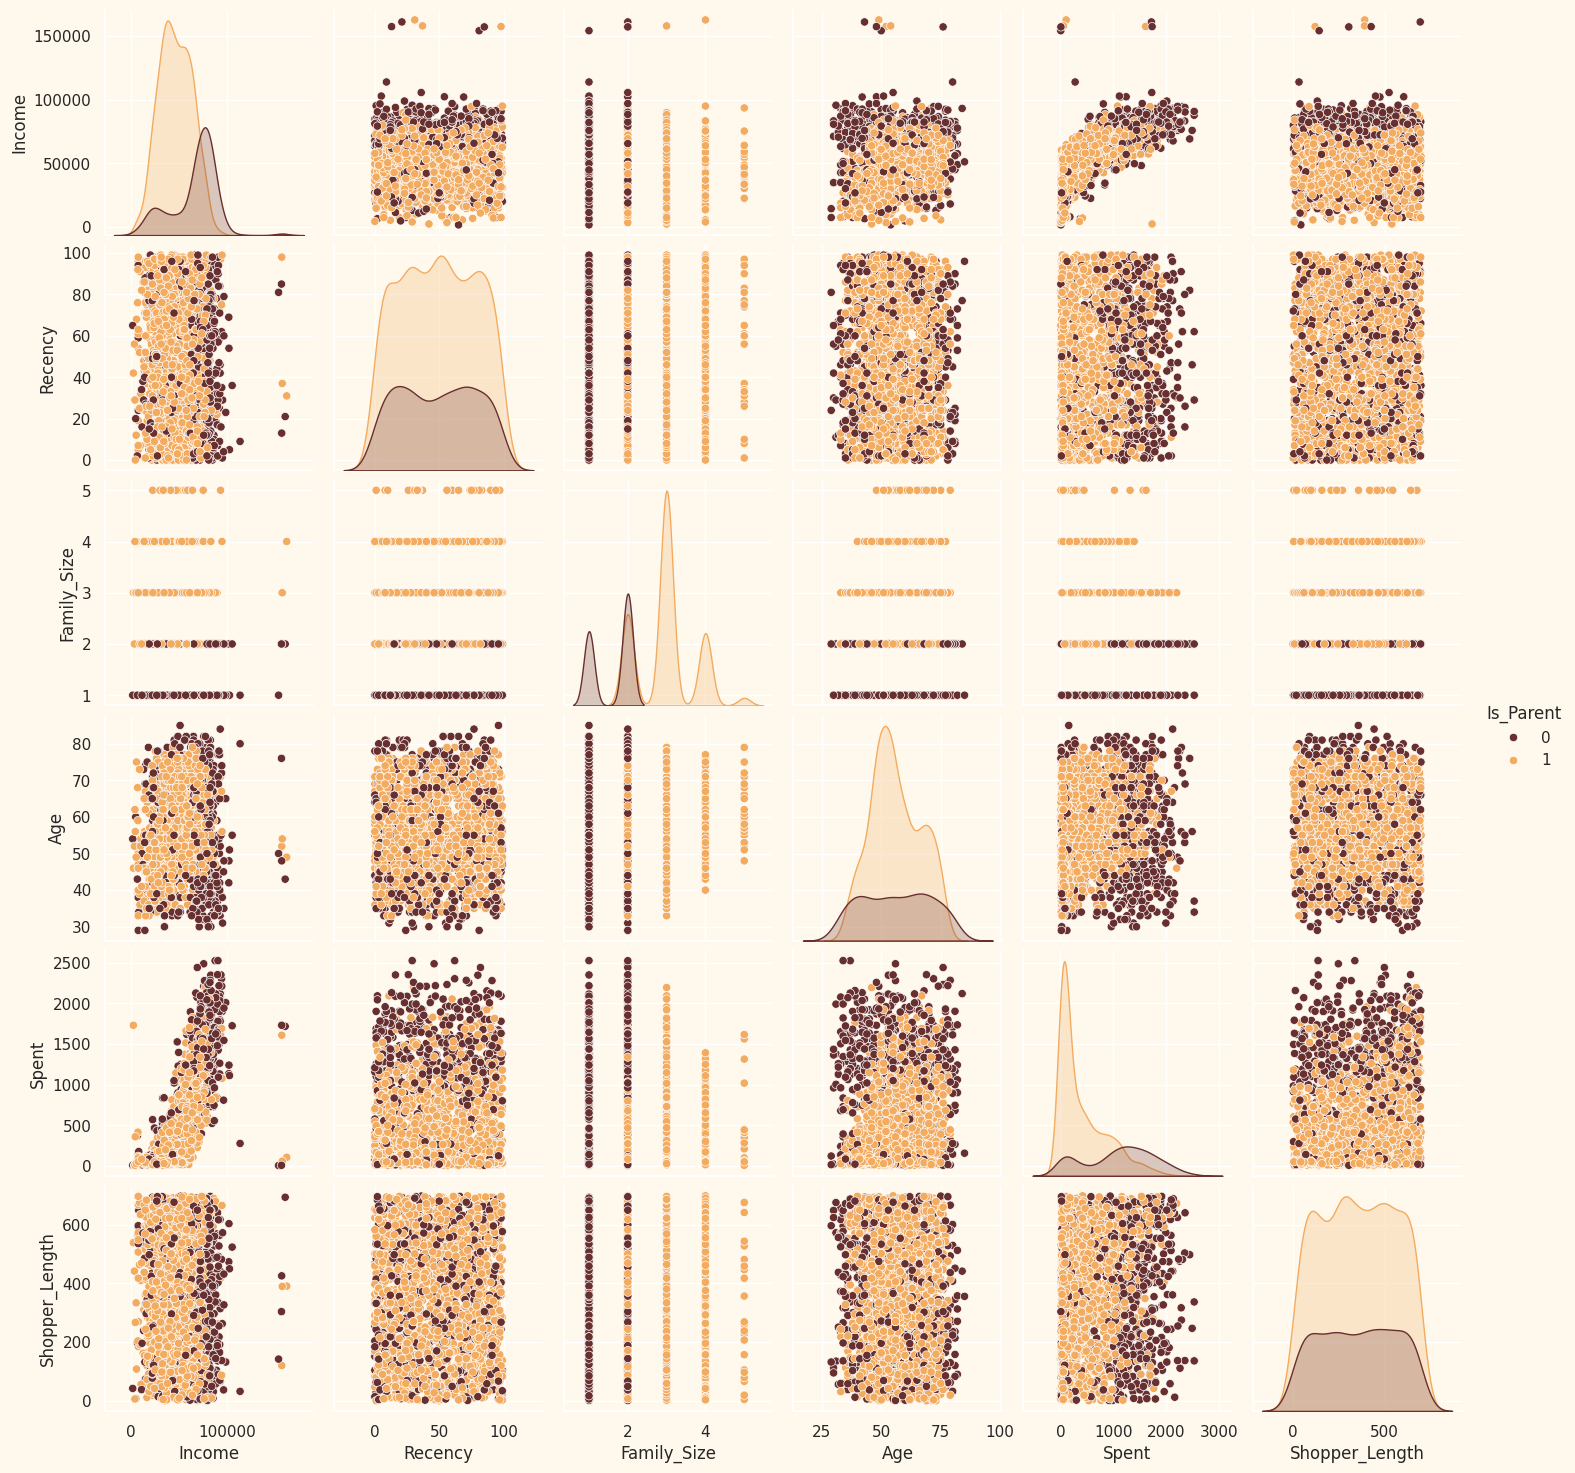

In [20]:
#To plot some selected features 
%matplotlib inline

#Setting up colors prefrences
sns.set_theme(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting following features
To_Plot = ["Income", "Recency", "Family_Size", "Age", "Spent", "Shopper_Length", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))

#Show plot 
plt.show()

Relative mapping of possibly related features: Data Subset


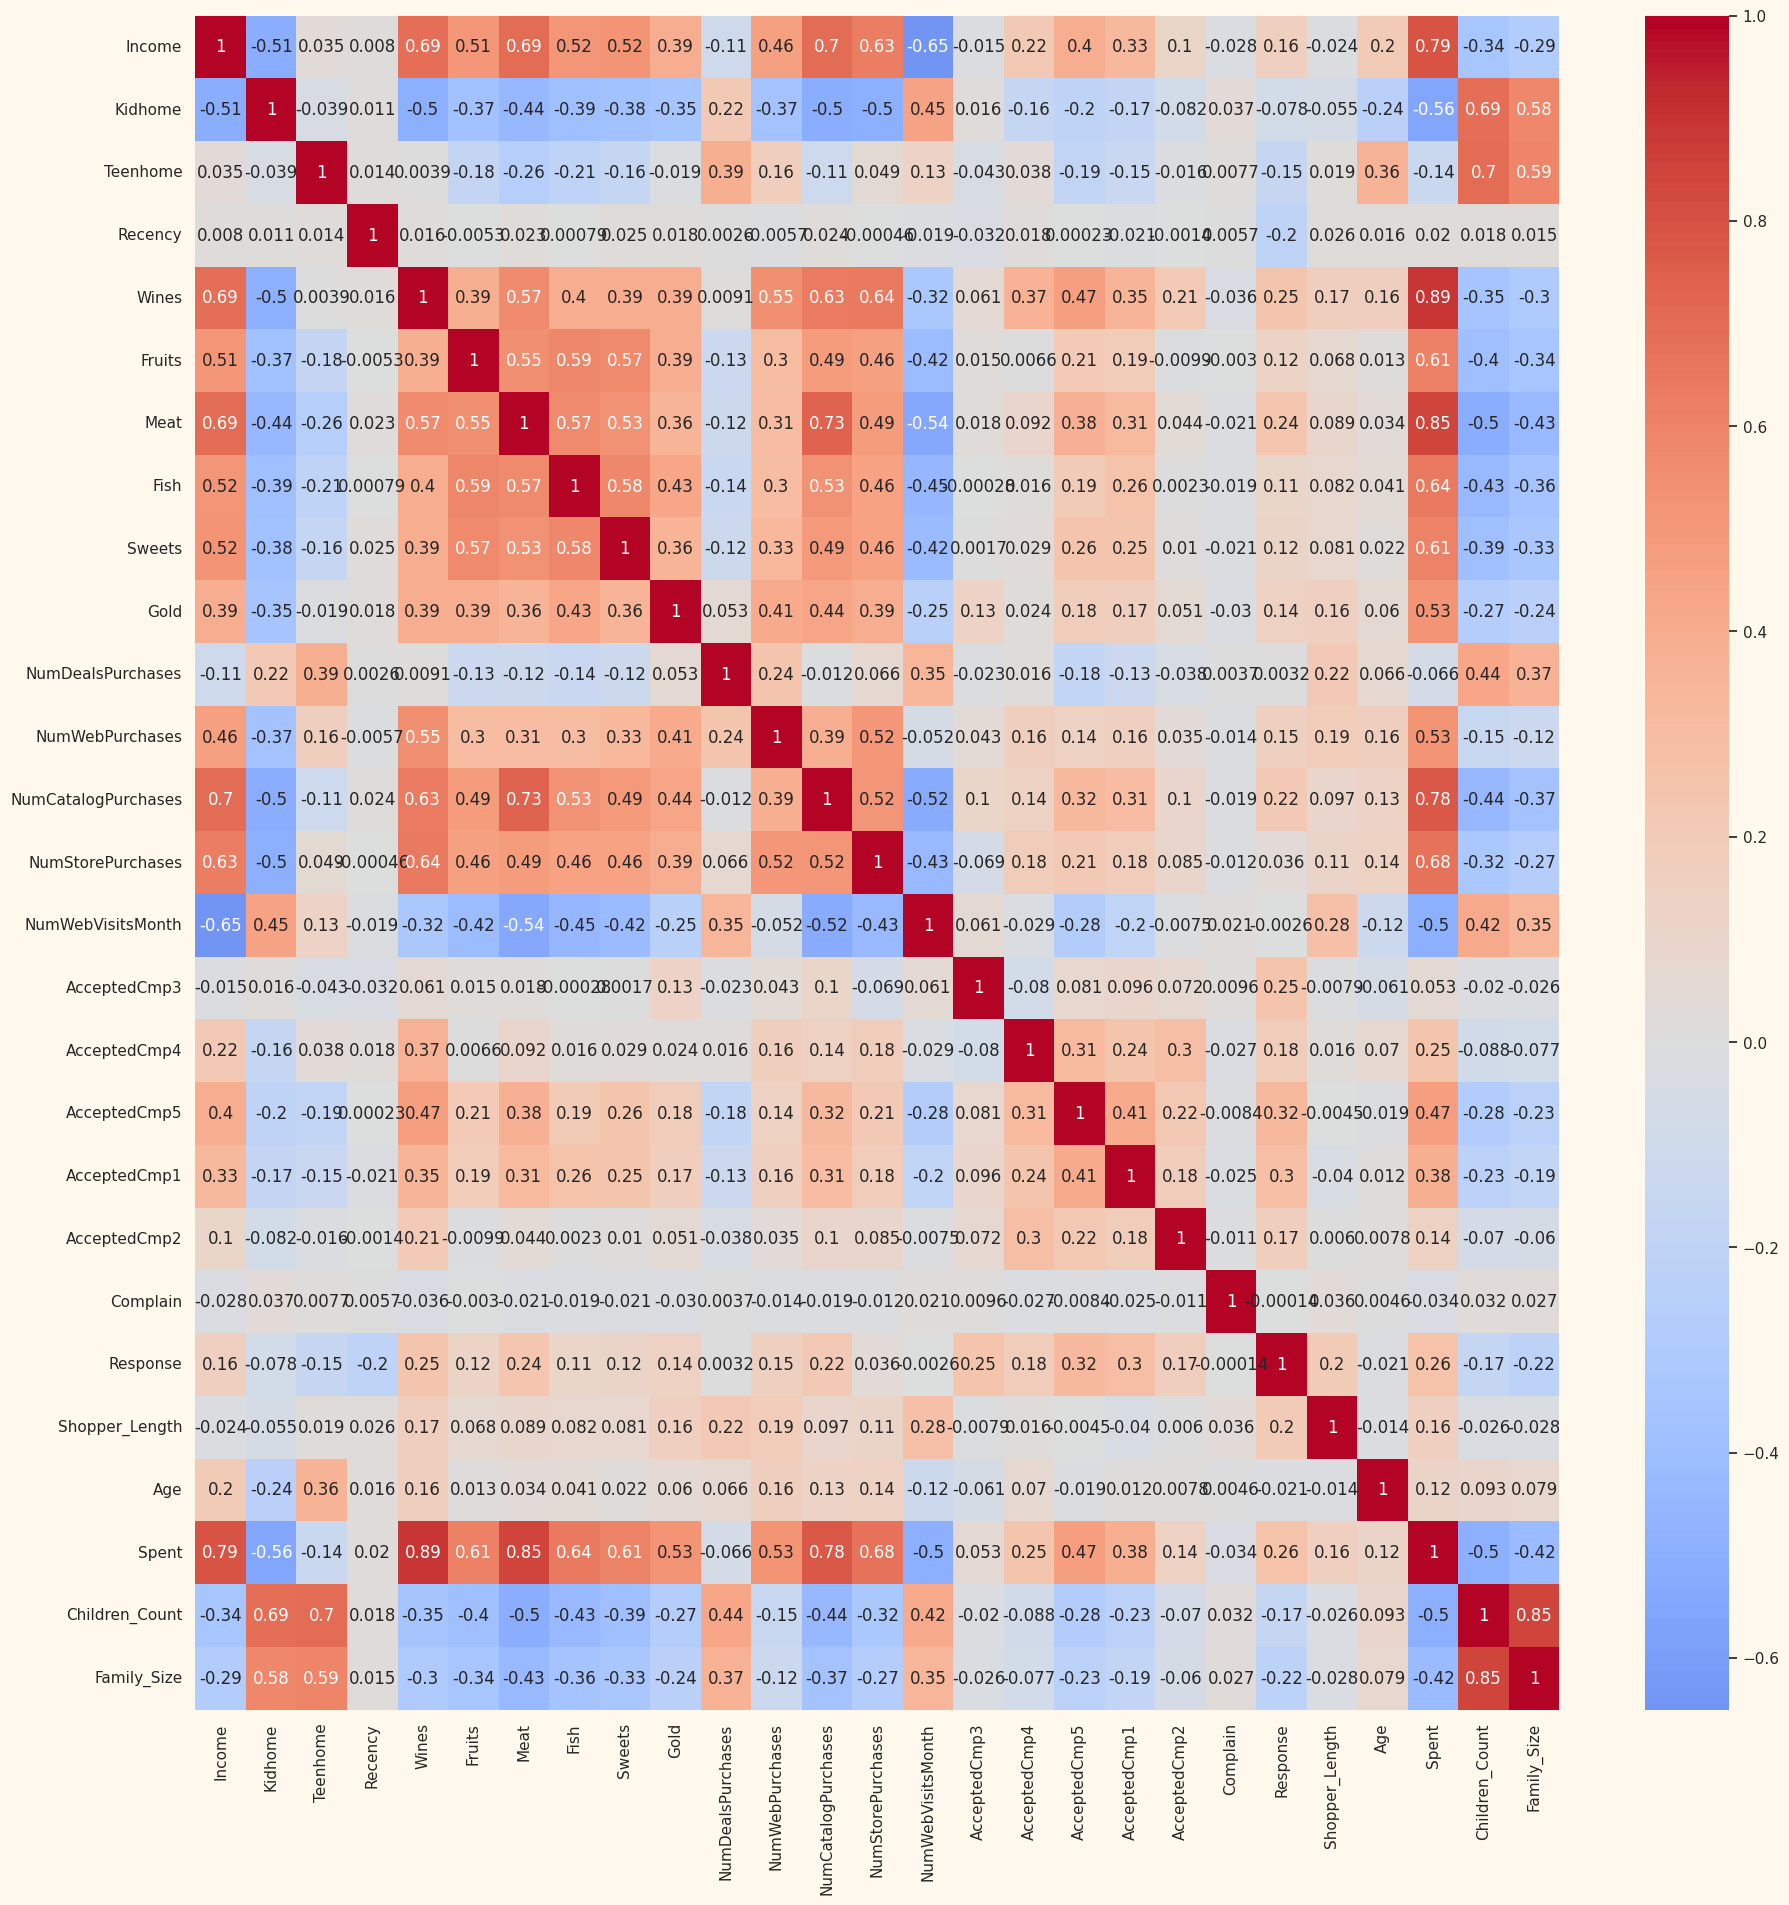

In [21]:
# Default theme
sns.set_theme(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Plot Income, Age, Recency, Spent, Family_Size, Is_Parent and Shopper_Length
data["Is_Parent"] = data["Is_Parent"].astype("category")
To_Plot = ["Income", "Recency", "Family_Size", "Age", "Spent", "Shopper_Length", "Is_Parent"]
print("Relative mapping of possibly related features: Data Subset")

# Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=["number"])
corrmat = numeric_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(22, 22))  # Adjust size as needed
sns.heatmap(corrmat, annot=True, cmap="coolwarm", center=0)
plt.show()

## Data Preprocessing

In [5]:
# Change categorical variables to numeric
categorical_index = (data.dtypes == 'object')
objects = list(categorical_index[categorical_index].index)

print("Categorical variables", objects)

Categorical variables ['Education', 'Living_With']


###### With this we can convert into numeric, using Label Encoding

In [6]:
LE = LabelEncoder()

# Loop through each column and assign number for category
for i in objects:
    data[i] = LE.fit_transform(data[i])

print(data["Education"].value_counts())
print(data["Living_With"].value_counts())

Education
0    1115
1     845
2     252
Name: count, dtype: int64
Living_With
1    1428
0     784
Name: count, dtype: int64


### Scaling the dataframe

###### I am going with Z-Score Scaling (scikit StandardScaler) because of the vastly different units, and compare them without losing relative differences. I also have trimmed the outliers for this as to not skew deviation.

In [7]:
# Copy the data 
data_copy = data.copy()
# Drop columns on deals accepted and complaints
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
data_copy.drop(cols_del, axis = 1, inplace= True)

# Scaling
scaler = StandardScaler()
scaler.fit(data_copy)
scaled_ds = pd.DataFrame(scaler.transform(data_copy), columns= data_copy.columns)

# Check Scaled data
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Shopper_Length,Age,Spent,Living_With,Children_Count,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


## Dimensionality Reduction Process

##### Reduce number of columns in my dataset while keeping the most useful information. I will be using scikits decomposition library's PCA to combine features into principle components. This will also allow easier 3D visualization.

In [8]:
# Reducing the dimensions to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,7.066881e-17,2.878602,-5.978124,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,3.212219e-17,1.709469,-4.194757,-1.323929,-0.173721,1.234851,6.168189
col3,2212.0,-1.525804e-17,1.231687,-3.625248,-0.853713,-0.050842,0.863974,6.750458


#### 3D Graph Of Data in New Dimensions

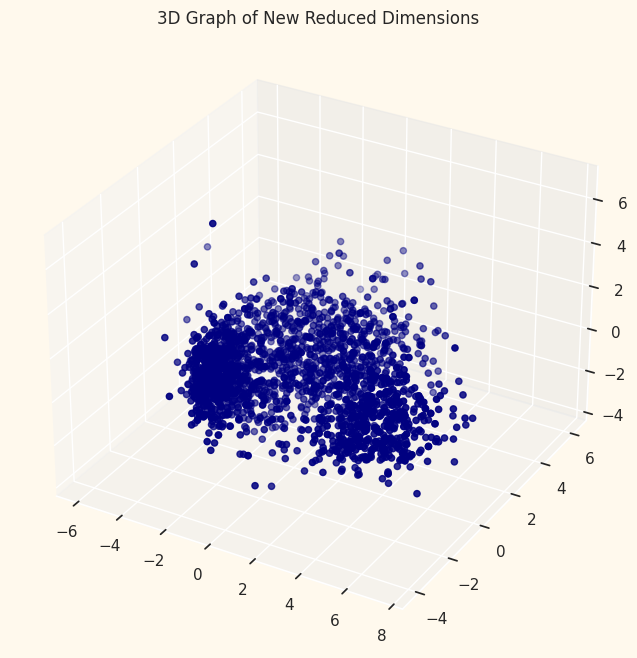

In [9]:
# Set axis for each Prinicple Component
x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]
#Plot the Dataset
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="navy", marker="o" )
ax.set_title("3D Graph of New Reduced Dimensions")
plt.show()

##### This confirms that the features have been reduced properly.

## Clustering

##### I will be using scikit Agglomerative Clustering recursively merges pairs using linkage distance.

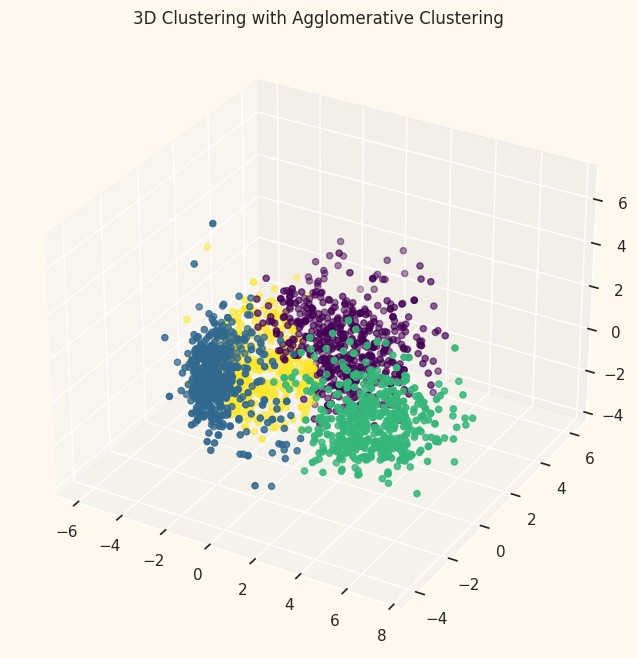

In [53]:
# Perform clustering
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')

# Fit and predict the clusters
clusters = agg_clustering.fit_predict(PCA_ds)

# Add cluster labels to dataset
PCA_ds['Cluster'] = clusters

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, c=PCA_ds['Cluster'], cmap="viridis", marker="o")
ax.set_title("3D Clustering with Agglomerative Clustering")
plt.show()

#### Evaluate the quality of clusters via silhouette score.

In [54]:
# Determine strength of clustered data
score = silhouette_score(PCA_ds[["col1", "col2", "col3"]], PCA_ds['Cluster'])
print(f"Silhouette Score: {score}")

Silhouette Score: 0.35548914964496076


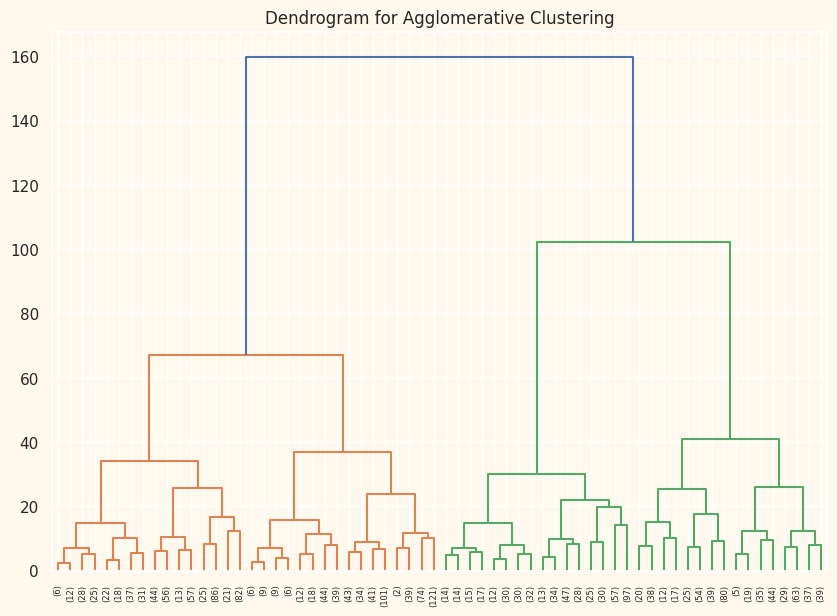

In [55]:
linked = linkage(PCA_ds[["col1", "col2", "col3"]], method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Dendrogram for Agglomerative Clustering")
plt.show()

## Evaluation of Models

##### This is unsupervised clustering, so this section will further explore the patterns in the clusters.

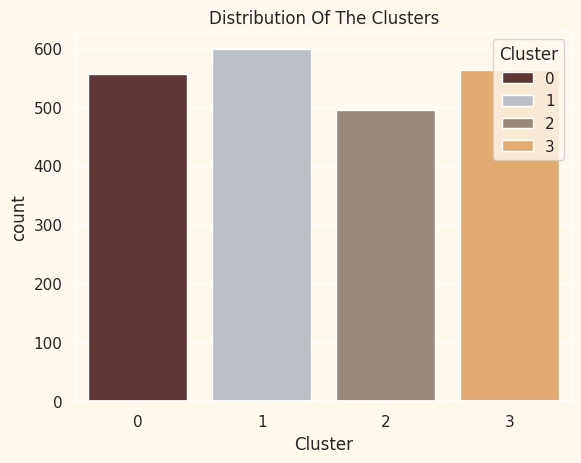

In [56]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x= PCA_ds["Cluster"], hue=PCA_ds["Cluster"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

###### The two clusters are distributed relatively evenly.

##### Looking at the two Clusters more in depth

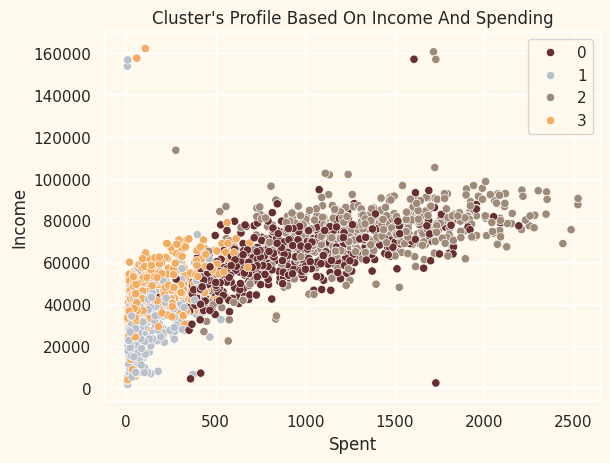

In [58]:
plot = sns.scatterplot(data = data, x= data["Spent"], y= data["Income"], hue=PCA_ds["Cluster"], palette= pal)
plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

- Cluster 0 is  High Spending, Average Income
- Cluster 1 is  Low Spending, Low Income
- Cluster 2 is  High Spending, High Income
- Cluster 3 is  Low Spending, Average Income

/home/terp/repos/customer-personality/venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 59.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/terp/repos/customer-personality/venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 33.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_57846/534886531.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(x=PCA_ds["Cluster"], y=data["Spent"], palette=pal)
/home/terp/repos/customer-personality/venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 64.2% of the points cannot be placed; you may want to decrease the size of the markers or 

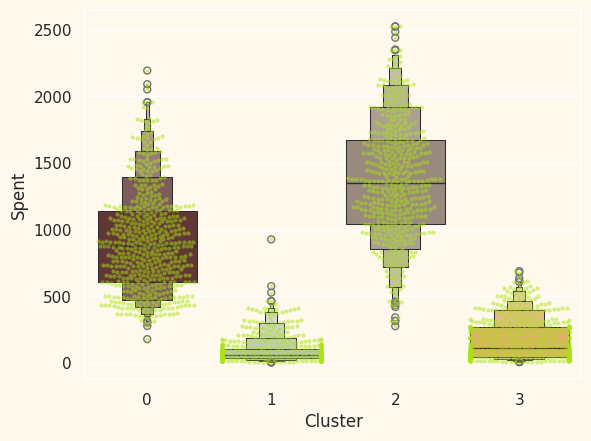

In [75]:
plt.figure()
pl=sns.swarmplot(x=PCA_ds["Cluster"], y=data["Spent"], color= "#ABE313", alpha=0.5, size= 3)
pl=sns.boxenplot(x=PCA_ds["Cluster"], y=data["Spent"], palette=pal)
plt.show()

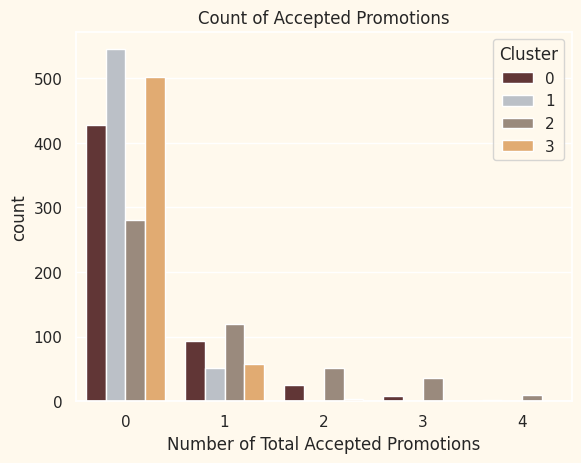

In [79]:
# Feature to get sum of all promotions taken
data["Sum_Promotions"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"]

plt.figure()
pl = sns.countplot(x=data["Sum_Promotions"], hue=PCA_ds["Cluster"], palette= pal)
pl.set_title("Count of Accepted Promotions")
pl.set_xlabel("Number of Total Accepted Promotions")
plt.show()

##### We can further compare this to our current Clusters

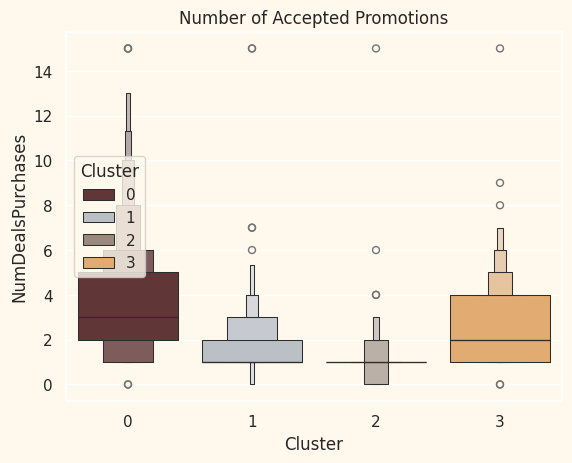

In [81]:
plt.figure()
plot = sns.boxenplot(data= data, x= PCA_ds["Cluster"], y= data["NumDealsPurchases"], hue= PCA_ds["Cluster"], palette= pal)
plot.set_title("Number of Accepted Promotions")
plt.show()